<img src="https://www.luxonis.com/logo.svg" width="400">

# Conversion of NVIDIA TAO model

## 🌟 Overview
In this tutorial, we'll go through converting a model from the [NVIDIA TAO toolkit](https://developer.nvidia.com/tao-toolkit) and [NGC Catalog](https://catalog.ngc.nvidia.com/models). We'll first download the model, test its inference, prepare it for deployment on a Luxonis device, and show how to deploy.

## 📜 Table of Contents
- [🛠️ Installation](#installation)
- [🗃️ Model Download and Export](#model-download)
- [✍ ONNX Model Test (Optional)](#model-test)
- [🗂️ Archive](#archive)
- [🤖 Deploy to HubAI](#deploy)
- [📷 DepthAI Script](#depthai-script)

<a name="installation"></a>

## 🛠️ Installation

### NVIDIA TAO Toolkit Installation

Recommended packages for NVIDIA TAO Toolkit are as follows:
* python >=3.7, <=3.10.x
* docker-ce > 19.03.5
* docker-API 1.40
* nvidia-container-toolkit > 1.3.0-1
* nvidia-container-runtime > 3.4.0-1
* nvidia-docker2 > 2.5.0-1
* nvidia-driver > 455+

Once you have installed the pre-requisites, please log in to the docker registry nvcr.io by following the command below

```sh
docker login nvcr.io
```

You will be triggered to enter a username and password. The username is `$oauthtoken` and the password is the API key generated from `ngc.nvidia.com`. Please follow the instructions in the [NGC setup guide](https://docs.nvidia.com/ngc/ngc-overview/index.html#generating-api-key) to generate your own API key.

More information on the installation can be found [here](https://docs.nvidia.com/tao/tao-toolkit/text/quick_start_guide/beginner.html).

In [ ]:
# Skip this cell if the TAO launcher was already installed.
!pip3 install nvidia-tao

In [ ]:
# View the version of the TAO launcher
!tao info

In [ ]:
%env KEY=nvidia_tao
%env USER_EXPERIMENT_DIR=/workspace/nvidia_tao_conversion


The cell below maps the project directory on your local host to a workspace directory in the TAO docker instance, so that the data and the results are mapped from in and out of the docker. For more information please refer to the [launcher instance](https://docs.nvidia.com/tao/tao-toolkit/text/tao_launcher.html) in the user guide.

In [2]:
import os
import json

os.environ["LOCAL_PROJECT_DIR"] = os.getcwd()
mounts_file = os.path.expanduser("~/.tao_mounts.json")

# Define the dictionary with the mapped drives
drive_map = {
    "Mounts": [
        # Mapping the data directory
        {
            "source": os.environ["LOCAL_PROJECT_DIR"],
            "destination": "/workspace/nvidia_tao_conversion"
        },
    ]
}

# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)

### Luxonis libraries installation

The main focus of this tutorial is using [`ModelConverter`](https://github.com/luxonis/modelconverter) for the conversion of a pre-trained model [`ReIdentificationNet`](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/reidentificationnet) from `NVIDIA TAO Toolkit` models catalog to formats supported by Luxonis devices. `ModelConverter` is our open-source tool for converting all RVC Compiled Formats. Furthermore, we'll also use [`LuxonisML`](https://github.com/luxonis/luxonis-ml) since it provides us with functionality to generate a [`NN Archive`](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/). Finally, we will use [`DepthAI v3`](https://rvc4.docs.luxonis.com/software/) and [`DepthaAI Nodes`](https://rvc4.docs.luxonis.com/software/ai-inference/depthai-nodes/) to run the converted model, process and visualize the results.

In [ ]:
%pip install -q pillow onnx onnxruntime modelconv@git+https://github.com/luxonis/modelconverter.git@main -U
%pip install -q depthai==3.0.0rc2 -U
%pip install -q depthai-nodes==0.3.0 -U

<a name="model-download"></a>

## 🗃️ Model Download and Export

The model can be obtained through the [NGC Registry CLI](https://docs.nvidia.com/ngc/gpu-cloud/ngc-private-registry-user-guide/index.html) or by getting a link directly from the [NGC Catalog](https://catalog.ngc.nvidia.com/models). The following command will download the model from the NGC Catalog:

In [ ]:
!wget --content-disposition 'https://api.ngc.nvidia.com/v2/models/org/nvidia/team/tao/reidentificationnet/trainable_v1.1/files?redirect=true&path=resnet50_market1501_aicity156.tlt' -O resnet50_market1501_aicity156.tlt

### ⚠️ Important Note
Models from the NGC Catalog which can be exported may have the following formats:
- `.tlt` (NVIDIA TAO Toolkit)
- `.pth` (PyTorch)
- `.pb` (TensorFlow)
- `.hdf5` (Keras)

Some models may be already exported to `.onnx` format. Then you can skip the export step and directly use the ONNX model for conversion to formats supported by Luxonis devices.

Some modesls require `encryption_key` or/and experiment configuration file `-e`. Please refer to the model documentation for more information or official [NVIDIA TAO Tutorial](https://github.com/NVIDIA/tao_tutorials/blob/main/notebooks/tao_launcher_starter_kit/re_identification_net/reidentificationnet_resnet.ipynb).

In [ ]:
!tao model re_identification export \
                   -e $USER_EXPERIMENT_DIR/media/experiment_market1501_resnet.yaml \
                   results_dir=$USER_EXPERIMENT_DIR \
                   encryption_key=$KEY \
                   export.checkpoint=$USER_EXPERIMENT_DIR/resnet50_market1501_aicity156.tlt \
                   export.onnx_file=$USER_EXPERIMENT_DIR/resnet50_market1501_aicity156.onnx

<a name="model-test"></a>

## ✍ ONNX Model Test (Optional)

Here we check the model's inference using the ONNX runtime. This is an optional step to ensure that the model is working as expected before converting it to the Luxonis format.

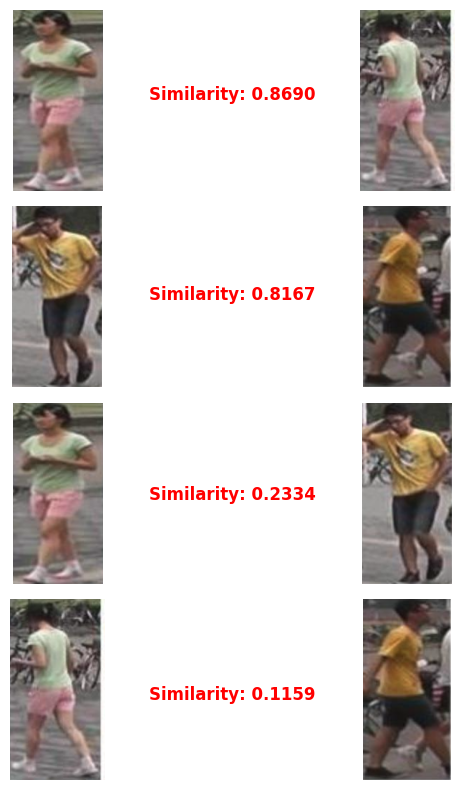

In [8]:
import onnxruntime as ort
import numpy as np
import cv2
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# Load ONNX model
model_path = "resnet50_market1501_aicity156.onnx" 
session = ort.InferenceSession(model_path)

# Get input details
input_name = session.get_inputs()[0].name
input_shape = session.get_inputs()[0].shape
input_shape = [1 if dim is None else dim for dim in input_shape]  # Fix batch size if needed
_, C, H, W = input_shape  # Expecting (batch, 3, 256, 128)

# Image preprocessing function
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(1, 3, 1, 1)
STD = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 3, 1, 1)

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (W, H))
    img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
    img = img.transpose(2, 0, 1)  # Convert to (C, H, W)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = (img - MEAN) / STD  # Apply mean/std normalization
    return img.astype(np.float32)  # Ensure float32 output

# Load and preprocess images
image_paths = ["person_0_0.png", "person_0_1.png", "person_1_0.png", "person_1_1.png"]
embeddings = {}

def normalize_embedding(emb):
    return emb / np.linalg.norm(emb)

for img_path in image_paths:
    img_tensor = preprocess_image(os.path.join("media", img_path))
    output = session.run(None, {input_name: img_tensor})[0]
    embeddings[img_path] = normalize_embedding(output.flatten())  # Flatten to 1D vector

# Compute cosine similarity between pairs
def cosine_similarity(emb1, emb2):
    return 1 - cosine(emb1, emb2)  # Higher value = more similar

pairs = [
    ("person_0_0.png", "person_0_1.png"),  # Same person
    ("person_1_0.png", "person_1_1.png"),  # Same person
    ("person_0_0.png", "person_1_0.png"),  # Different persons
    ("person_0_1.png", "person_1_1.png")   # Different persons
]

# Display pairs with similarity scores
fig, axes = plt.subplots(len(pairs), 2, figsize=(10, 8))

for i, (img1, img2) in enumerate(pairs):
    img1_path = os.path.join("media", img1)
    img2_path = os.path.join("media", img2)
    sim = cosine_similarity(embeddings[img1], embeddings[img2])

    # Load images for visualization
    img1_data = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
    img2_data = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)

    # Show first image
    axes[i, 0].imshow(img1_data)
    axes[i, 0].axis("off")

    # Show second image
    axes[i, 1].imshow(img2_data)
    axes[i, 1].axis("off")

    # Add centered similarity score
    fig.text(0.5, 1 - ((i + 0.5) / len(pairs)), f"Similarity: {sim:.4f}", 
             ha="center", va="center", fontsize=12, color="red", weight="bold")

plt.tight_layout()
plt.show()


<a name="archive"></a>

## 🗂️ Archive

Once we are satisfied with the model's performance, we want to prepare it for deployment on the device. We want to package this exported model into a `NN Archive`.

The code below creates the `NN Archive`.

In [ ]:
from luxonis_ml.nn_archive import ArchiveGenerator
from luxonis_ml.nn_archive.config_building_blocks import (
    DataType,
    InputType,
)
from luxonis_ml.nn_archive.config import CONFIG_VERSION

# Define the configuration dictionary
config = {
    "config_version": CONFIG_VERSION, # draw config version from luxonis-ml
    "model": {
        "metadata": {
            "name": "resnet50_market1501_aicity156",
            "path": "resnet50_market1501_aicity156.onnx",
            "precision": DataType.FLOAT32
        },
        "inputs": [
            {
                "name": "input",
                "dtype": DataType.FLOAT32,
                "input_type": InputType.IMAGE, 
                "shape": [
                    1,
                    3,
                    256,
                    128
                ],
                "layout": "NCHW",
                "preprocessing": {
                    "mean": [123.675, 116.28, 103.53],
                    "scale": [58.395, 57.12, 57.375]
                }
            }
        ],
        "outputs": [
            {
                "name": "fc_pred",
                "dtype": DataType.FLOAT32,
                "shape": [
                    1,
                    256
                ],
                "layout": "NC"
            }
        ],
        "heads": [
            {   "parser": "EmbeddingsParser",
                "metadata": {
                    "postprocessor_path": None,
                },
                "outputs": ["fc_pred"]
            }
        ]
    }
}

archive = ArchiveGenerator(
    archive_name="resnet50_market1501_aicity156", # Define string name of the generated archive.
    save_path="./", # Define string path to where you want to save the archive file.
    cfg_dict=config,
    executables_paths=["resnet50_market1501_aicity156.onnx"], # Define a list of string paths to relevant model executables.
)
archive.make_archive()

<a name="deploy"></a>

## 🤖 Deploy to HubAI

Now that we have successfully archived the model, we aim to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. We will show you how to use our [`ModelConverter`](https://github.com/luxonis/modelconverter) to convert the model as simply as possible. More information about conversion and deployment can be found in the [ONNX Conversion Notebook](https://github.com/luxonis/depthai-ml-training/blob/main/conversion/onnx_conversion.ipynb).

In [ ]:
!modelconverter hub login

In [ ]:

# =============================================================================
# RVC4 conversion
# =============================================================================
!modelconverter hub convert rvc4 --path "resnet50_market1501_aicity156.tar.xz" \
                                --name "ReIdentification NVIDIA TAO" \
                                --description-short "ReIdentificationNet takes cropped images of a person from different perspectives as network input and outputs the embedding features for that person." \
                                --license-type "MIT" \
                                --no-is-public

# =============================================================================
# RVC2 conversion
# =============================================================================
# !modelconverter hub convert rvc4 --path "resnet50_market1501_aicity156.tar.xz" \
#                                 --name "ReIdentification NVIDIA TAO" \
#                                 --description-short "ReIdentificationNet takes cropped images of a person from different perspectives as network input and outputs the embedding features for that person." \
#                                 --license-type "MIT" \
#                                 --no-is-public

Now we can see the model card in [HubAI](https://hub.luxonis.com/ai/models).

<img src="./media/reidentificationnet_model_exported.png" alt="Exported model on HubAI" width="800">

### ⚠️ Improtant Note
Some models may have unsupported operations or layers that are not supported by available formats. In such cases, you may need to modify the model or use a different model that is supported by the Luxonis devices. Alternatively, you can contact us for further assistance.

<a name="depthai-script"></a>

## 📷 DepthAI Script

An example script to run the model on the Luxonis device can be found [here](https://github.com/luxonis/depthai-experiments/tree/gen3/neural-networks/reidentification/human-reidentification). This script uses the `DepthAI` library to run the model on the device and visualize the results.


You can run the following command to run the script from the above link:
```bash
python main.py -det luxonis/scrfd-person-detection:25g-640x640     -rec luxonis/reidentification-nvidia-tao:<INSERT YOUR MODEL ID HERE>     -cos 0.8     -fps 5
```

### ⚠️ Important Note
Some NVIDIA TAO models may require additional post-processing steps. Post-processing code for most models can be found [here](https://github.com/NVIDIA/tao_pytorch_backend)

Congratulations! You've completed the tutorial and successfully deployed the pre-trained ReIdentificationNet model to Luxonis camera. Great job! 🎉🎉🎉